In [29]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
from glob import glob
from pathlib import Path
from tqdm import tqdm

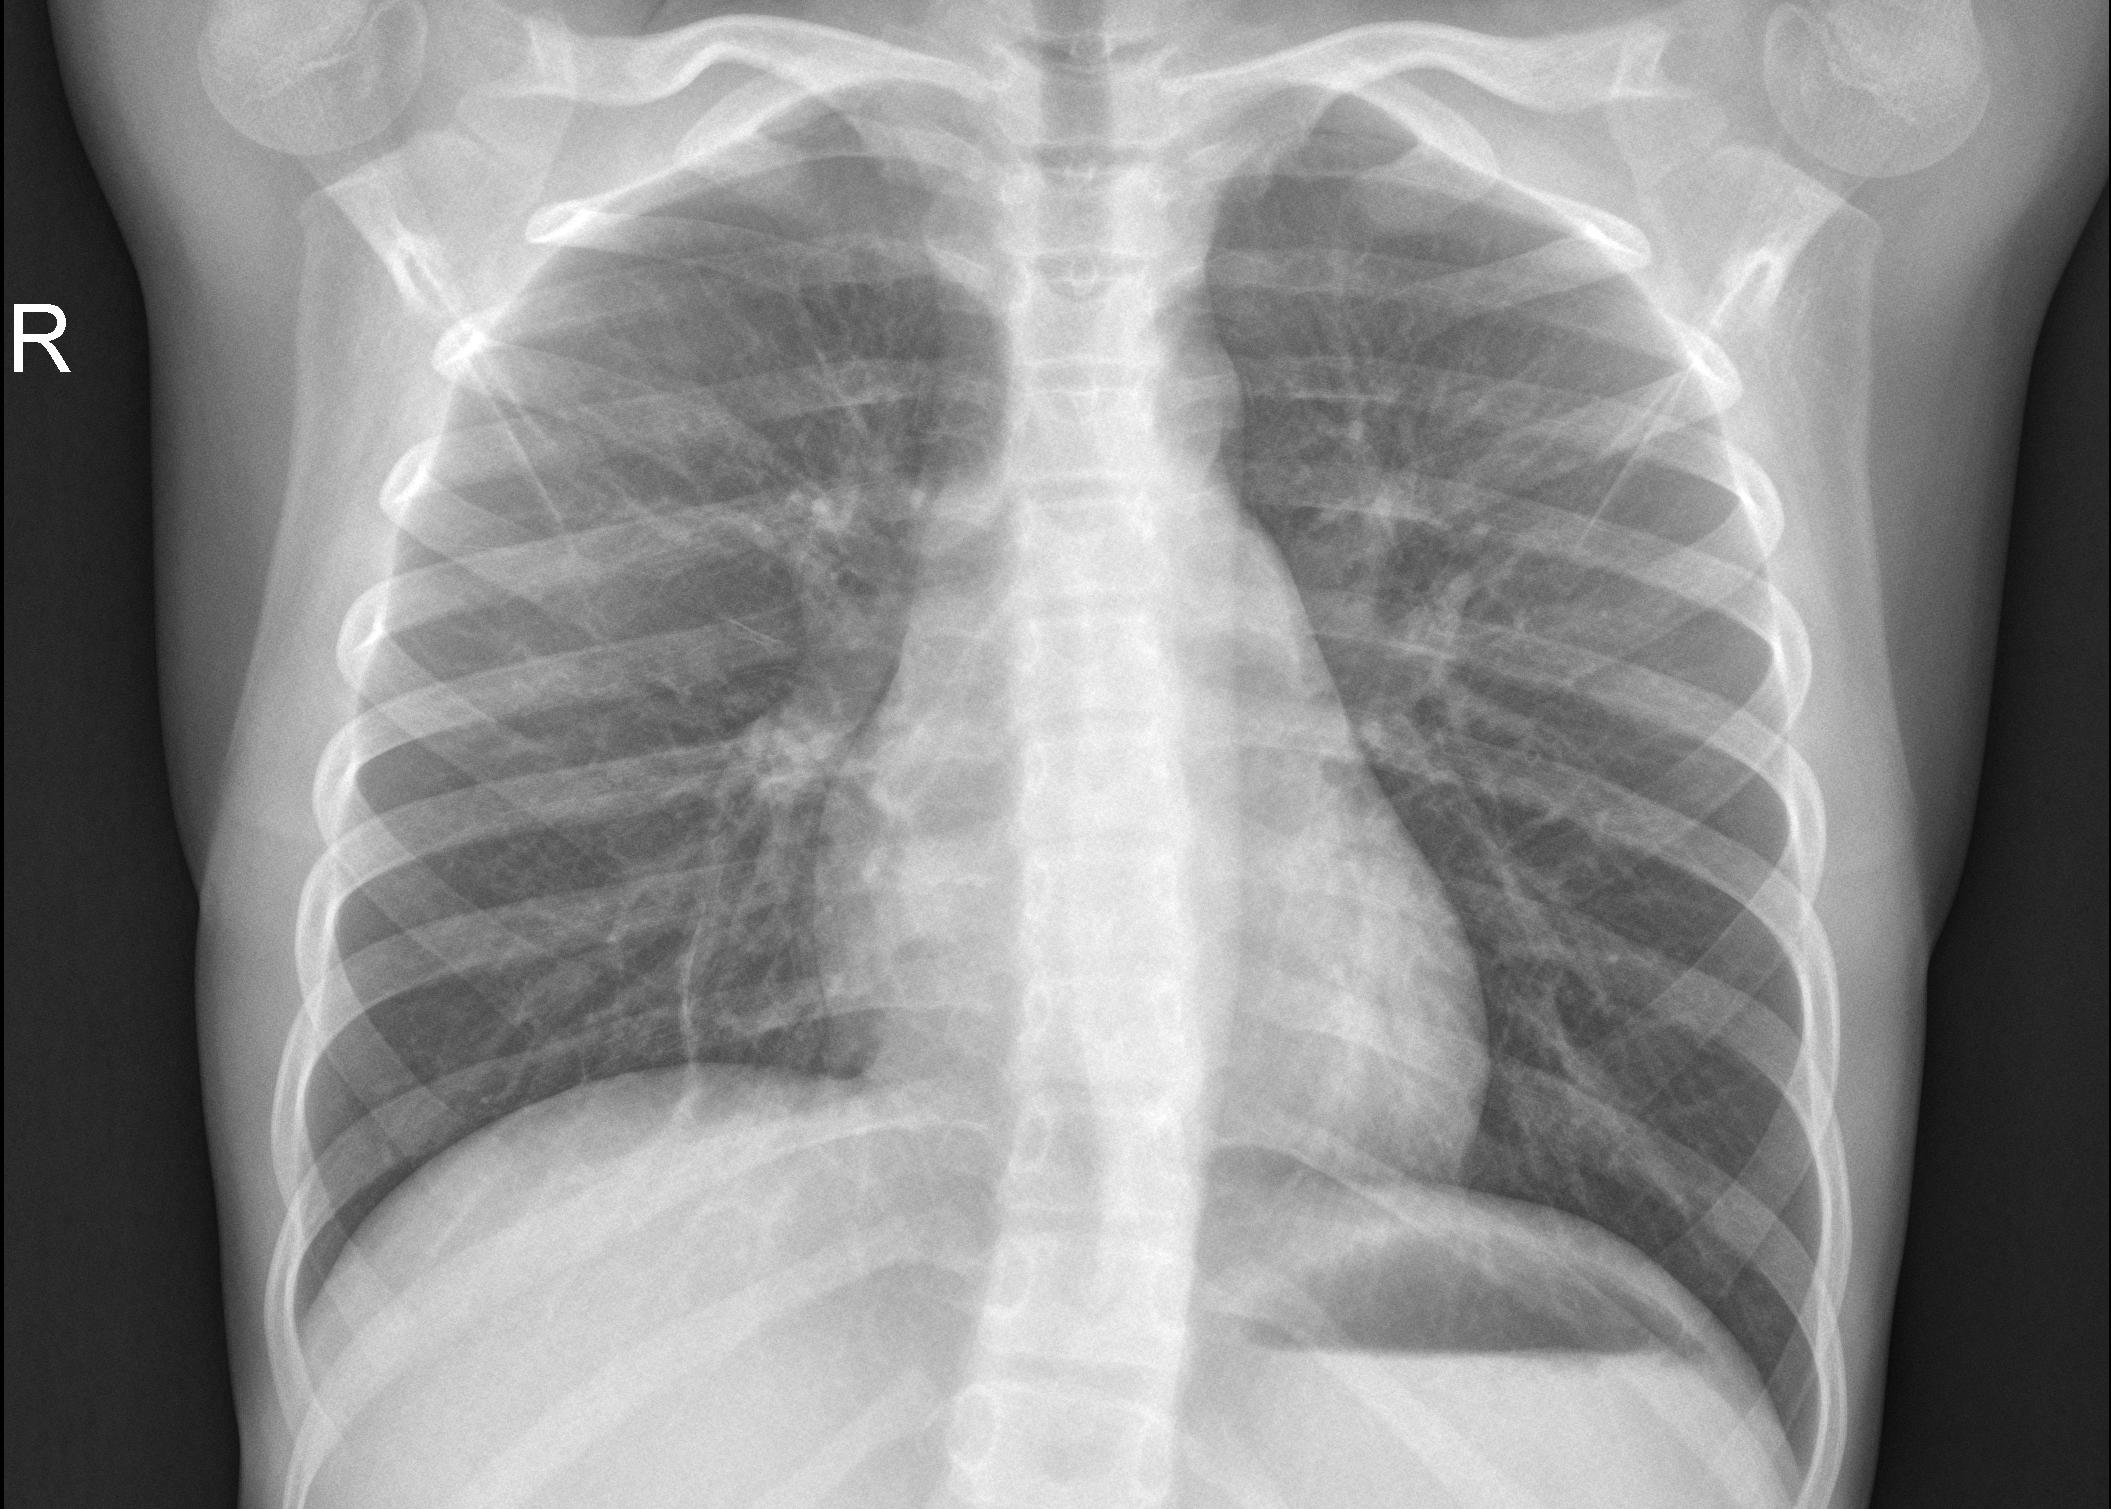

In [17]:
Image.open(r"chest_xray/test/NORMAL/IM-0003-0001.jpeg")

In [2]:
import pandas as pd

In [32]:
def build_data_map(folder_path):

    img_path = glob(folder_path + "/*.jpeg")

    clas = Path(folder_path).name
    split = Path(folder_path).parent.name

    return pd.DataFrame({
        "path_imgs" :img_path,
        "Clas" :clas,
        "split" :split
    })

test_normal   = build_data_map("chest_xray/test/NORMAL")
test_pneumal  = build_data_map("chest_xray/test/PNEUMONIA")

train_normal  = build_data_map("chest_xray/train/NORMAL")
train_pneumal = build_data_map("chest_xray/train/PNEUMONIA")

val_normal    = build_data_map("chest_xray/val/NORMAL")
val_pneumal   = build_data_map("chest_xray/val/PNEUMONIA")



In [33]:
Data = pd.concat([
    test_normal,
    test_pneumal,
    train_normal,
    train_pneumal,
    val_normal,
    val_pneumal
])

In [34]:
Data

,path_imgs,Clas,split
0,chest_xray/test/NORMAL/NORMAL2-IM-0325-0001.jpeg,NORMAL,test
1,chest_xray/test/NORMAL/IM-0084-0001.jpeg,NORMAL,test
2,chest_xray/test/NORMAL/NORMAL2-IM-0349-0001.jpeg,NORMAL,test
3,chest_xray/test/NORMAL/NORMAL2-IM-0150-0001.jpeg,NORMAL,test
4,chest_xray/test/NORMAL/NORMAL2-IM-0198-0001.jpeg,NORMAL,test
...,...,...,...
3,chest_xray/val/PNEUMONIA/person1949_bacteria_4...,PNEUMONIA,val
4,chest_xray/val/PNEUMONIA/person1946_bacteria_4...,PNEUMONIA,val
5,chest_xray/val/PNEUMONIA/person1950_bacteria_4...,PNEUMONIA,val
6,chest_xray/val/PNEUMONIA/person1951_bacteria_4...,PNEUMONIA,val


In [36]:
resized_imgs_path = []

for i,row in tqdm( Data.iterrows() ,total = Data.shape[0]):
    img_path = row["path_imgs"]
    img = Image.open(img_path)
    resized_imgs = img.resize((224,224))

    img_path = Path(img_path)
    img_name = img_path.name
    img_clas = img_path.parent.name
    img_split = img_path.parent.parent.name
    

    final_img_name = img_split + "_" + img_clas + "_"+img_name
    final_img_path = "resize/" + final_img_name
    

    resized_imgs.save(final_img_path)

    resized_imgs_path.append(final_img_path)
    

    






100%|██████████| 5856/5856 [01:03<00:00, 91.88it/s] 


In [37]:
Data["resized"]= resized_imgs_path

In [40]:
Data.to_csv("DATA/data_map.csv",index=False)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class XRayDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        df: DataFrame فيه الأعمدة
            - "resized_imgs" : مسار الصورة
            - "Clas"        : اسم الكلاس
            - "split"       : train / val / test
        transform: التحويلات على الصورة
        """
        self.df = df
        self.transform = transform
        self.classes = sorted(df["Clas"].unique())
        self.class2idx = {cls: i for i, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["resized"]
        img = Image.open(img_path).convert("RGB")  

        if self.transform:
            img = self.transform(img)

        label = self.class2idx[row["Clas"]]
        return img, label


In [ ]:

train_df = Data[Data["split"]=="train"]
val_df   = Data[Data["split"]=="val"]
test_df  = Data[Data["split"]=="test"]

train_dataset = XRayDataset(train_df, transforms.ToTensor())
val_dataset   = XRayDataset(val_df, transforms.ToTensor())
test_dataset  = XRayDataset(test_df, transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
import torch.nn as nn
from torchvision import models

def get_model(model_name, num_classes=2):
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError("Unknown model")
    return model


In [ ]:
import torch.optim as optim
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def train_model(model, train_loader, val_loader, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = correct / total
        print(f"Epoch {epoch+1}, Val Accuracy: {acc:.4f}")

    return model


In [65]:
models_to_train = ["resnet18", "efficientnet_b0", "densenet121"]
trained_models = {}

for m in models_to_train:
    print(f"\nTraining {m} ...")
    model = get_model(m, num_classes=2)
    trained_model = train_model(model, train_loader, val_loader, epochs=5)
    trained_models[m] = trained_model



Training resnet18 ...
Epoch 1, Val Accuracy: 0.8750
Epoch 2, Val Accuracy: 1.0000
Epoch 3, Val Accuracy: 1.0000
Epoch 4, Val Accuracy: 0.8750
Epoch 5, Val Accuracy: 0.6875

Training efficientnet_b0 ...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/mohamed/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:06<00:00, 3.36MB/s]


Epoch 1, Val Accuracy: 1.0000
Epoch 2, Val Accuracy: 0.8750
Epoch 3, Val Accuracy: 0.9375
Epoch 4, Val Accuracy: 0.9375
Epoch 5, Val Accuracy: 0.9375

Training densenet121 ...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/mohamed/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:08<00:00, 3.64MB/s]


Epoch 1, Val Accuracy: 0.5625
Epoch 2, Val Accuracy: 1.0000
Epoch 3, Val Accuracy: 1.0000
Epoch 4, Val Accuracy: 0.8125
Epoch 5, Val Accuracy: 0.9375


In [66]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

for m, model in trained_models.items():
    acc = evaluate_model(model, test_loader)
    print(f"{m} Test Accuracy: {acc:.4f}")


resnet18 Test Accuracy: 0.8125
efficientnet_b0 Test Accuracy: 0.8269
densenet121 Test Accuracy: 0.7692


In [ ]:
import torch
from pathlib import Path

save_dir = Path("models")
save_dir.mkdir(exist_ok=True)

for model_name, model in trained_models.items():
    torch.save(model.state_dict(), save_dir / f"{model_name}.pth")
    print(f"Saved {model_name} successfully!")


Saved resnet18 successfully!
Saved efficientnet_b0 successfully!
Saved densenet121 successfully!


In [ ]:
models_to_train = ["resnet18", "efficientnet_b0", "densenet121"]


In [92]:
from PIL import Image
from torchvision import transforms

IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def predict_image(model, img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, dim=1)

    classes = ["NORMAL", "PNEUMONIA"]
    return classes[pred.item()], conf.item()



In [93]:
model = get_model("efficientnet_b0")
predict_image(model, "DATA/chest_xray/test/NORMAL/IM-0033-0001-0001.jpeg")


('NORMAL', 0.540938138961792)

In [133]:

def load_resnet(path):
    model = models.resnet18(weights=None)
    model.fc = torch.nn.Linear(512, 2)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

def load_vgg(path):
    model = models.densenet121(weights=None)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

def load_efficient(path):
    model = models.efficientnet_b0(weights=None)
    model.classifier[1] = torch.nn.Linear(1280, 2)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model


In [134]:

all_models = {
    "resnet18": load_resnet("models/resnet18.pth"),
    "densenet121": load_vgg("models/densenet121.pth"),
    "efficientnet": load_efficient("models/efficientnet_b0.pth")
}


In [135]:
len(all_models)

3